In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the first difference dataset
diff_df = pd.read_csv('../../02_data/02.02_processed/acs_brfss_21_22_diff.csv')

# Load original dataset for reference
original_df = pd.read_csv('../../02_data/02.02_processed/acs_brfss_21_22.csv')

# Basic info about the difference dataset
print(f"Shape of difference dataset: {diff_df.shape}")
diff_df.head()

Shape of difference dataset: (3068, 42)


,fips,diff_brfss_access2,diff_brfss_checkup,diff_brfss_csmoking,diff_brfss_depression,diff_brfss_diabetes,diff_brfss_ghlth,diff_brfss_mhlth,diff_brfss_obesity,diff_acs_pct_age_gte65,...,diff_acs_pct_ses_pov,diff_acs_pct_sex_female,diff_acs_pct_sex_male,diff_acs_pct_tp_veh_0,diff_acs_pct_tp_veh_1,diff_acs_pct_tp_veh_2,diff_acs_pct_tp_veh_3,diff_acs_pop_tot,diff_brfss_totalpopulation,period
0,1001,-1.4,1.9,-1.5,1.6,0.6,0.4,0.0,-0.5,0.5,...,-2.2,-0.4,0.4,-1.4,0.2,0.9,0.3,522,664,2021_2022
1,1003,0.1,4.2,-0.3,1.9,0.4,1.8,0.9,-0.4,0.6,...,1.0,-0.1,0.1,-0.1,-0.6,-0.7,1.5,6289,7141,2021_2022
2,1005,-0.6,2.5,-3.1,0.9,0.4,1.1,0.6,0.4,0.8,...,-2.3,0.8,-0.8,0.5,0.0,-1.8,1.2,-382,-258,2021_2022
3,1007,-1.2,3.6,-0.2,3.3,0.9,3.1,1.9,1.8,0.8,...,3.7,1.4,-1.4,1.2,0.7,-2.5,0.5,-161,-472,2021_2022
4,1009,3.0,2.5,-0.1,3.8,1.1,4.0,2.3,-0.4,0.3,...,1.0,-0.5,0.5,0.3,-0.1,0.6,-0.8,193,471,2021_2022


In [46]:
# Get key health and socioeconomic difference variables
key_vars = [col for col in diff_df.columns if 'diff_' in col and any(x in col for x in 
                                                               ['diabetes', 'obesity', 'pov', 'income', 'bb_int', 'uninsured'])]

# Display summary statistics for key variables
diff_df[key_vars].describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
diff_acs_pct_dg_bb_int,3068.0,1.901336,1.940121,-9.5,0.9,1.6,2.7,18.9
diff_brfss_diabetes,3068.0,0.565971,0.767286,-3.7,0.1,0.6,1.1,5.5
diff_brfss_obesity,3068.0,0.532366,2.619939,-8.9,-1.2,0.5,2.2,10.8
diff_acs_pct_ses_pov,3068.0,-0.062353,1.591597,-10.9,-0.8,-0.1,0.6,10.3


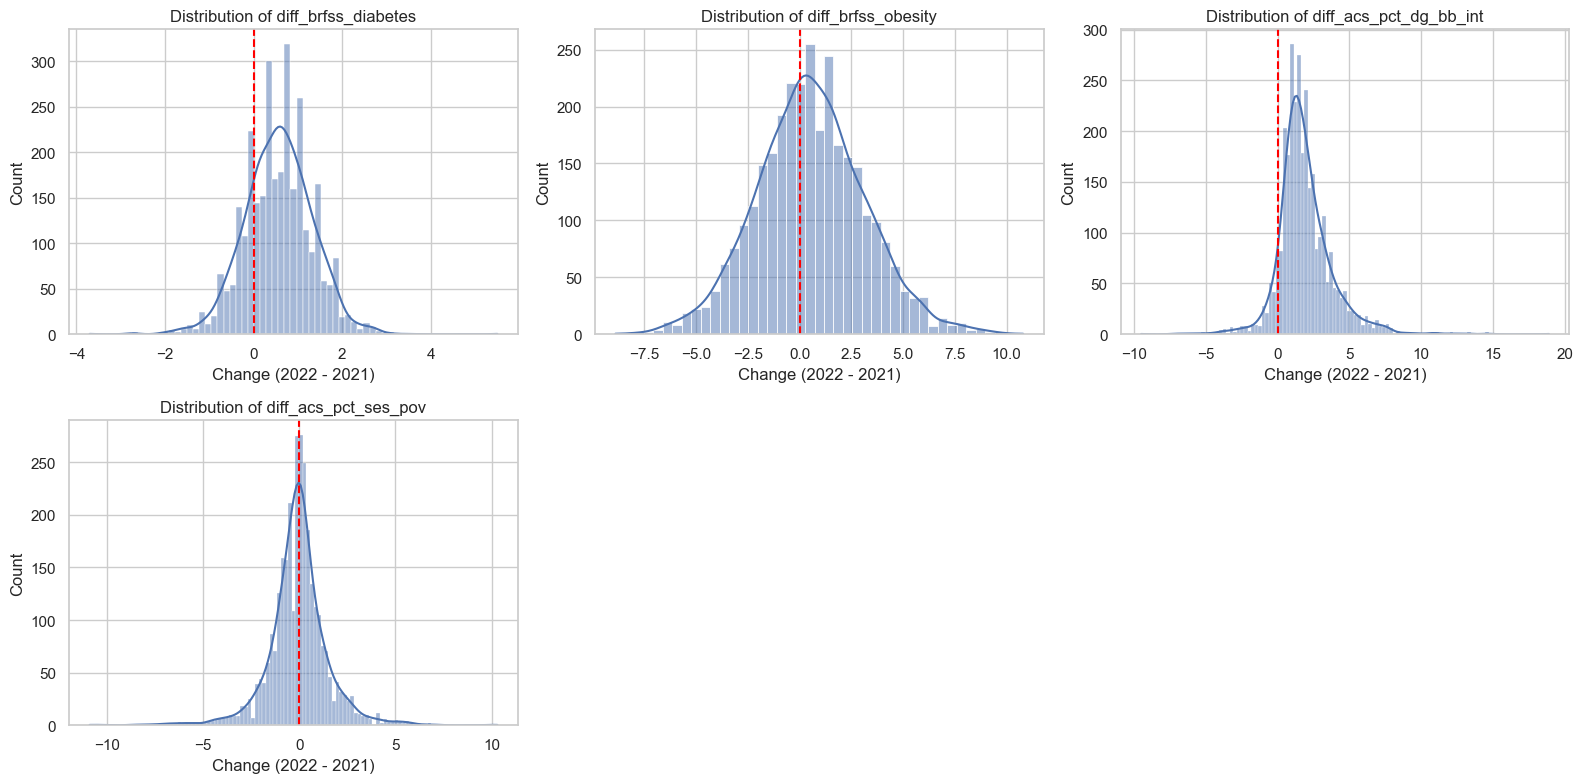

In [47]:
# Distribution of changes in key variables

# Create function to plot histograms for multiple variables
def plot_diff_distributions(dataframe, variables, ncols=3):
    nrows = int(np.ceil(len(variables) / ncols))
    fig = plt.figure(figsize=(16, nrows * 4))
    gs = gridspec.GridSpec(nrows, ncols)
    
    for i, var in enumerate(variables):
        ax = plt.subplot(gs[i])
        sns.histplot(dataframe[var], kde=True, ax=ax)
        ax.set_title(f'Distribution of {var}')
        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_xlabel('Change (2022 - 2021)')
    
    plt.tight_layout()
    plt.show()

# Plot distributions of key variables
plot_diff_distributions(diff_df, key_vars)

In [48]:
# Counties with largest positive and negative changes in diabetes prevalence

# Find county names from original dataset
fips_to_county = original_df[['fips', 'acs21_name']].set_index('fips')['acs21_name'].to_dict()
diff_df['county_name'] = diff_df['fips'].map(fips_to_county)

# Get diabetes difference column
diabetes_diff_col = [col for col in diff_df.columns if 'diff_' in col and 'diabetes' in col][0]

# Top 10 counties with largest increase in diabetes
print("Top 10 counties with largest INCREASE in diabetes prevalence:")
top_increase = diff_df.sort_values(by=diabetes_diff_col, ascending=False)[['county_name', diabetes_diff_col]].head(10)
display(top_increase)

# Top 10 counties with largest decrease in diabetes
print("\nTop 10 counties with largest DECREASE in diabetes prevalence:")
top_decrease = diff_df.sort_values(by=diabetes_diff_col)[['county_name', diabetes_diff_col]].head(10)
display(top_decrease)

Top 10 counties with largest INCREASE in diabetes prevalence:


,county_name,diff_brfss_diabetes
2579,"Kenedy County, Texas",5.5
2525,"Floyd County, Texas",3.5
998,"Martin County, Kentucky",3.1
2496,"Concho County, Texas",3.1
2619,"Moore County, Texas",2.9
2471,"Briscoe County, Texas",2.8
112,"Arkansas County, Arkansas",2.8
2699,"Yoakum County, Texas",2.8
2479,"Cameron County, Texas",2.8
2533,"Garza County, Texas",2.7



Top 10 counties with largest DECREASE in diabetes prevalence:


,county_name,diff_brfss_diabetes
2347,"Todd County, South Dakota",-3.7
2353,"Ziebach County, South Dakota",-2.8
1790,"Orleans County, New York",-2.7
2334,"Mellette County, South Dakota",-2.7
2290,"Bennett County, South Dakota",-2.1
342,"Clay County, Georgia",-2.0
83,"Kusilvak Census Area, Alaska",-2.0
1770,"Franklin County, New York",-1.9
1332,"Bolivar County, Mississippi",-1.9
2322,"Jackson County, South Dakota",-1.8


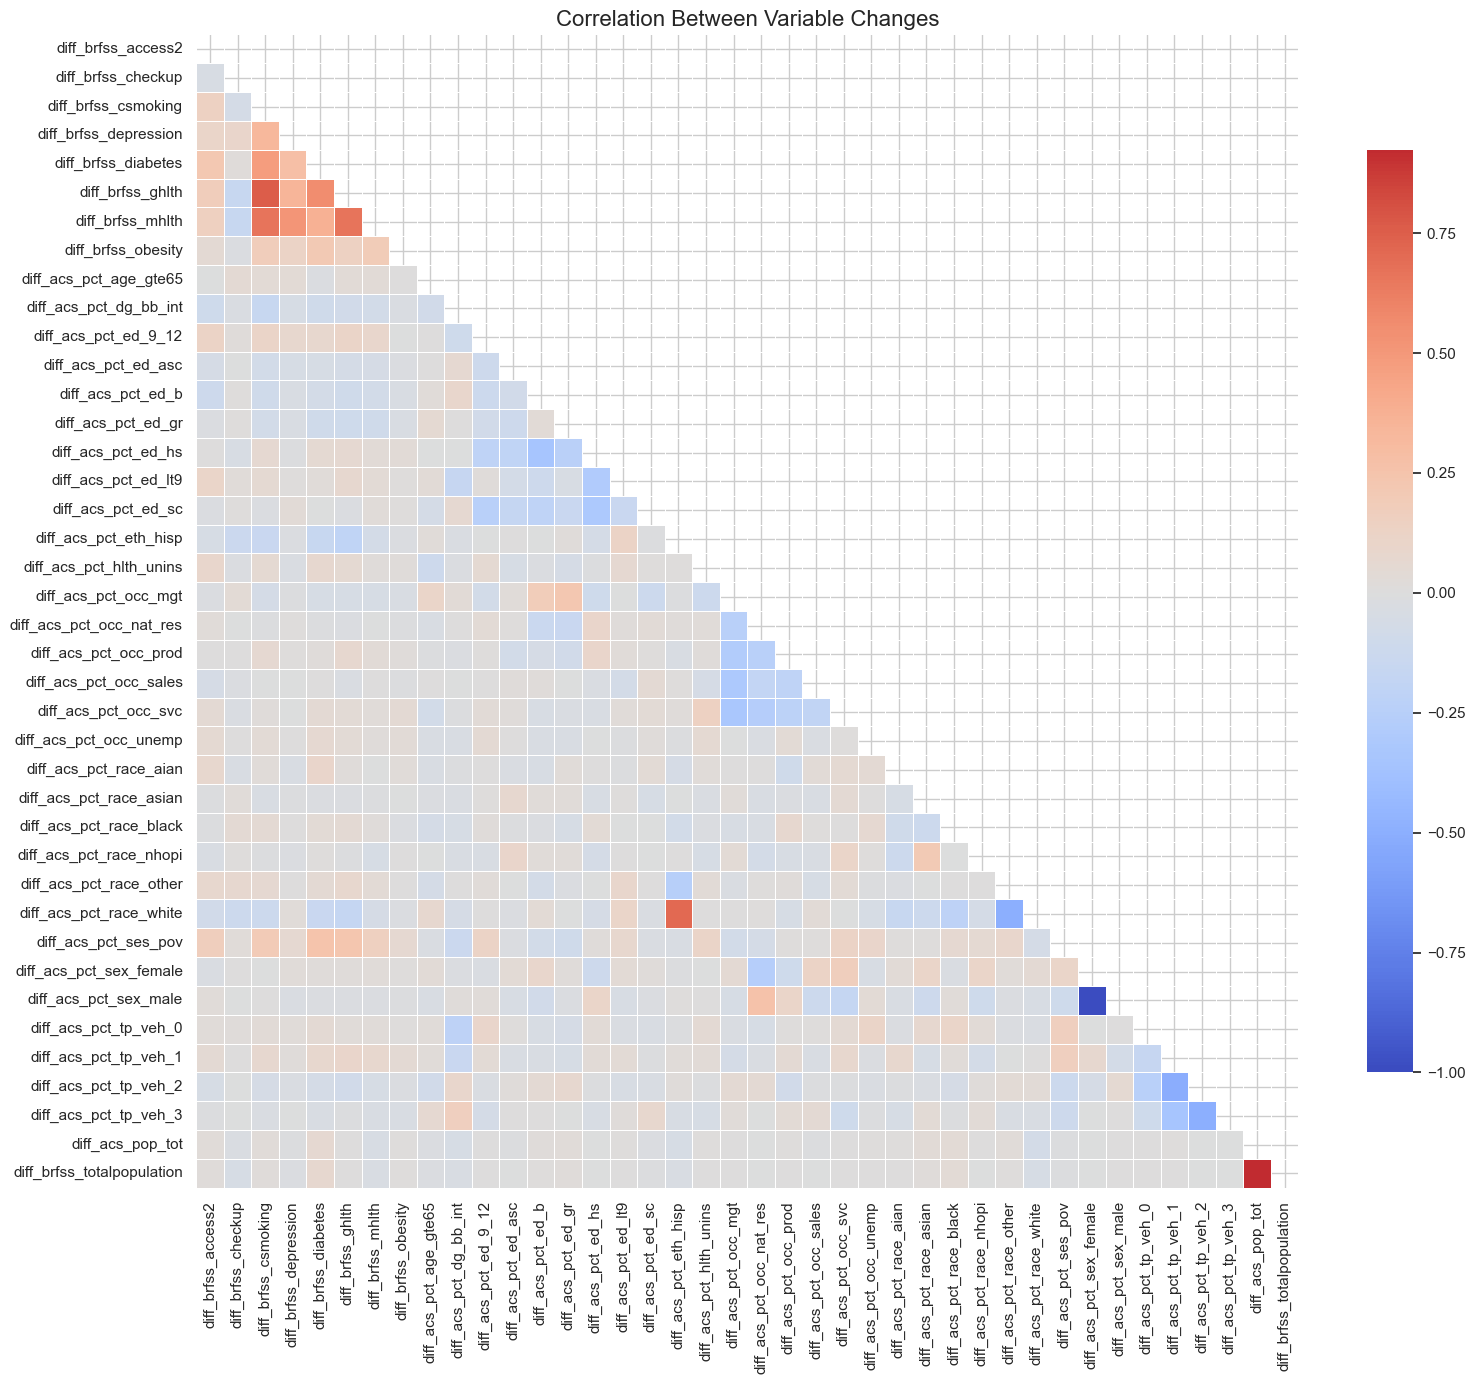

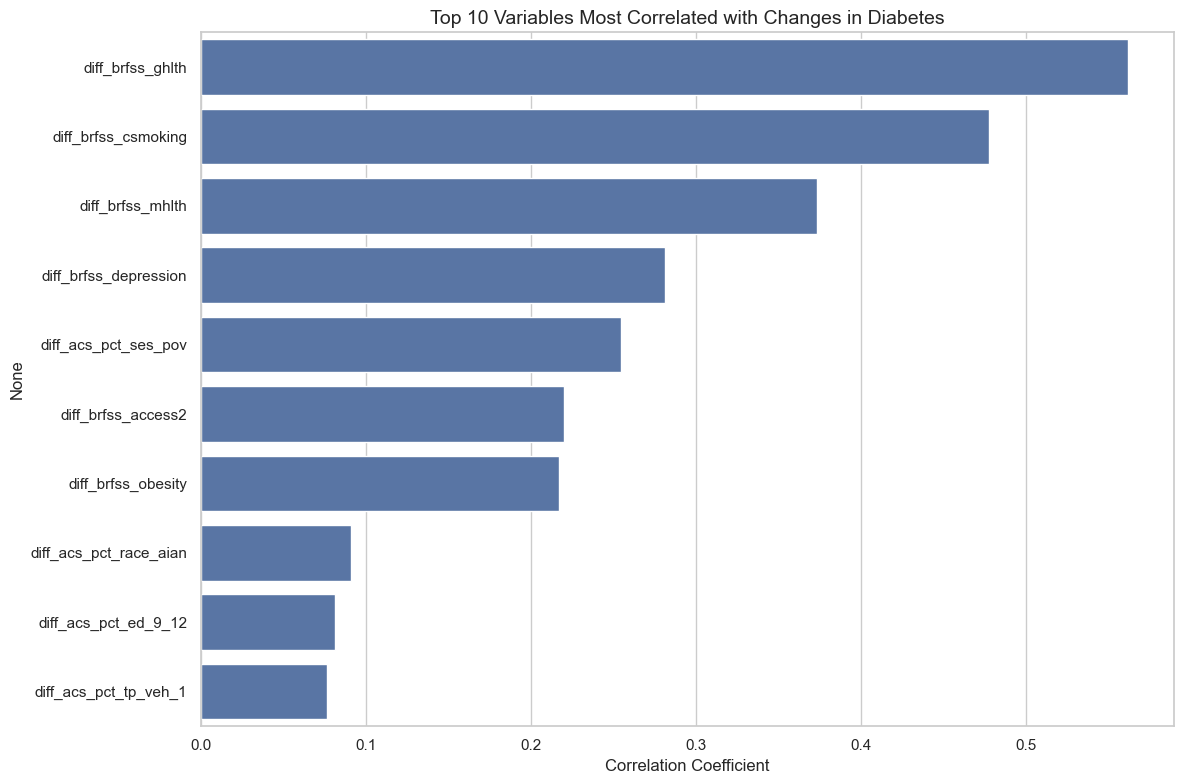

In [49]:
# Select only the difference columns
diff_cols = [col for col in diff_df.columns if col.startswith('diff_')]

# Calculate correlation matrix
corr_matrix = diff_df[diff_cols].corr()

# Plot heatmap of correlations
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Between Variable Changes', fontsize=16)
plt.tight_layout()
plt.show()

# Focus on correlations with diabetes change
diabetes_corr = corr_matrix[diabetes_diff_col].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=diabetes_corr.values[1:11], y=diabetes_corr.index[1:11])
plt.title(f'Top 10 Variables Most Correlated with Changes in Diabetes', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [50]:
dv_int = [
    'diff_brfss_diabetes' # BRFSS Age-Adjusted Prevalence (2022-2021)
]

dv_struct = [
    'diff_acs_pct_dg_bb_int' #ACS Broadband Adoption - Household (2022-2021)
]

structural = [
    'diff_acs_pct_age_gte65',
    'diff_acs_pct_ed_9_12', 
    'diff_acs_pct_ed_asc', 
    'diff_acs_pct_ed_b',
    'diff_acs_pct_ed_gr', 
    'diff_acs_pct_ed_hs', 
    #'diff_acs_pct_ed_lt9', #reference
    'diff_acs_pct_ed_sc', 
    'diff_acs_pct_eth_hisp', 
    'diff_acs_pct_occ_mgt',
    'diff_acs_pct_occ_nat_res', 
    'diff_acs_pct_occ_prod',
    'diff_acs_pct_occ_sales', 
    'diff_acs_pct_occ_svc',
    #'diff_acs_pct_occ_unemp', #reference
    'diff_acs_pct_race_aian',
    'diff_acs_pct_race_asian', 
    'diff_acs_pct_race_black',
    'diff_acs_pct_race_nhopi', 
    'diff_acs_pct_race_other',
    'diff_acs_pct_race_white', 
    'diff_acs_pct_ses_pov',
    'diff_acs_pct_sex_male',
    'diff_acs_pop_tot'
]

index = [
    'fips',
    'county_name'
]

In [51]:
diff_df

# Normalize diff_acs_pop_tot to -100 to 100 scale
# First, find min and max values
min_pop_diff = diff_df['diff_acs_pop_tot'].min()
max_pop_diff = diff_df['diff_acs_pop_tot'].max()

# Find the absolute maximum value to ensure symmetric scaling
abs_max = max(abs(min_pop_diff), abs(max_pop_diff))

# Apply normalization formula to scale to -100 to 100 range
diff_df['diff_acs_pop_tot'] = diff_df['diff_acs_pop_tot'] / abs_max * 100


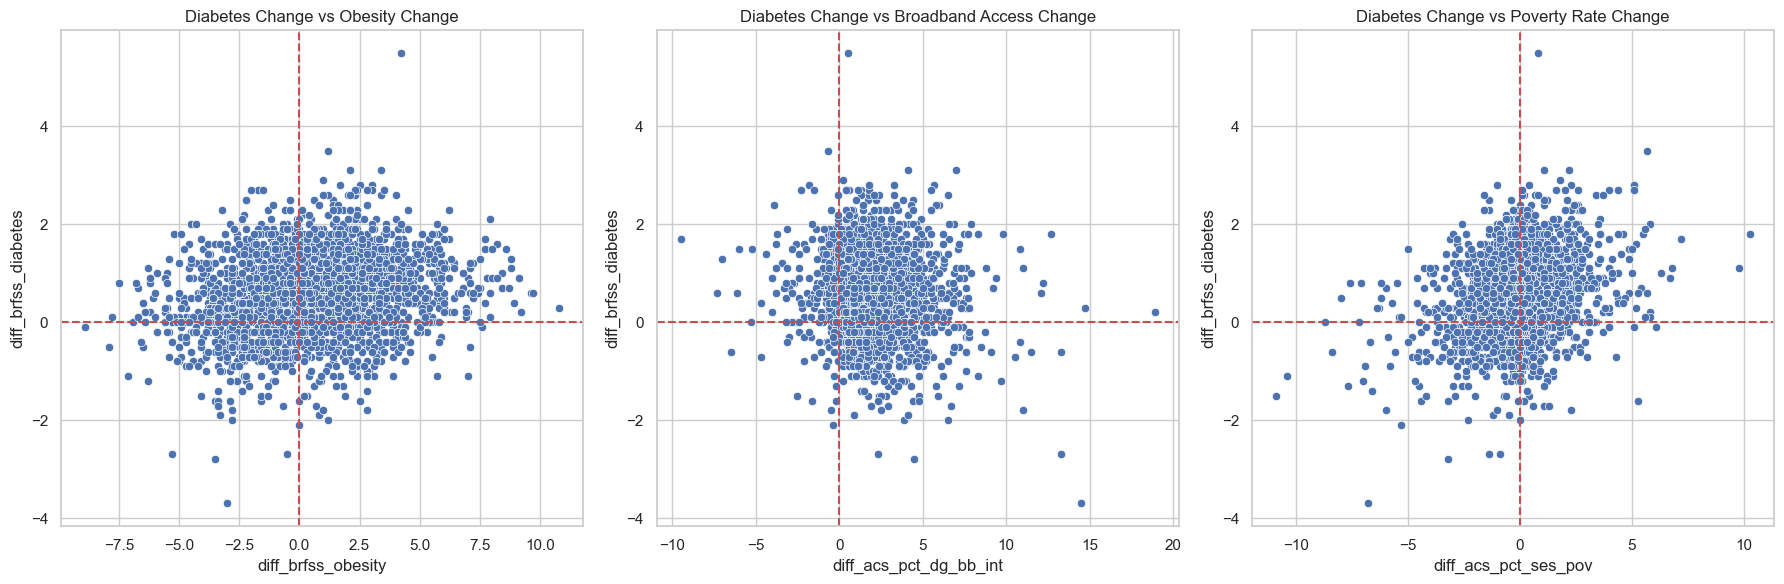

In [52]:
# Scatter plots to visualize relationships between changes
# Example: Changes in diabetes vs changes in obesity

obesity_diff_col = [col for col in diff_df.columns if 'diff_' in col and 'obesity' in col][0]
broadband_diff_col = [col for col in diff_df.columns if 'diff_' in col and 'bb_int' in col][0]
poverty_diff_col = [col for col in diff_df.columns if 'diff_' in col and 'pov' in col][0]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Diabetes change vs Obesity change
sns.scatterplot(data=diff_df, x=obesity_diff_col, y=diabetes_diff_col, ax=axs[0])
axs[0].set_title('Diabetes Change vs Obesity Change')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].axvline(x=0, color='r', linestyle='--')

# Diabetes change vs Broadband change
sns.scatterplot(data=diff_df, x=broadband_diff_col, y=diabetes_diff_col, ax=axs[1])
axs[1].set_title('Diabetes Change vs Broadband Access Change')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].axvline(x=0, color='r', linestyle='--')

# Diabetes change vs Poverty change
sns.scatterplot(data=diff_df, x=poverty_diff_col, y=diabetes_diff_col, ax=axs[2])
axs[2].set_title('Diabetes Change vs Poverty Rate Change')
axs[2].axhline(y=0, color='r', linestyle='--')
axs[2].axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [53]:
# Test if mean change in diabetes is significantly different from 0
t_stat, p_value = stats.ttest_1samp(diff_df[diabetes_diff_col].dropna(), 0)
print(f"T-test for diabetes change: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
print(f"Mean change in diabetes: {diff_df[diabetes_diff_col].mean():.4f}")
if p_value < 0.05:
    print("The change in diabetes prevalence is statistically significant")
else:
    print("The change in diabetes prevalence is not statistically significant")

# Test other key variables
for var in structural: 
    t_stat, p_value = stats.ttest_1samp(diff_df[var].dropna(), 0)
    print(f"\nT-test for {var}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Mean change: {diff_df[var].mean():.4f}")
    if p_value < 0.05:
        print(f"The change in Structural SDOH variable {var} is statistically significant")
    else:
        print(f"***The change in {var} is not statistically significant")

T-test for diabetes change: t-statistic = 40.8569, p-value = 0.0000
Mean change in diabetes: 0.5660
The change in diabetes prevalence is statistically significant

T-test for diff_acs_pct_age_gte65: t-statistic = 37.4850, p-value = 0.0000
Mean change: 0.5073
The change in Structural SDOH variable diff_acs_pct_age_gte65 is statistically significant

T-test for diff_acs_pct_ed_9_12: t-statistic = -17.4364, p-value = 0.0000
Mean change: -0.2860
The change in Structural SDOH variable diff_acs_pct_ed_9_12 is statistically significant

T-test for diff_acs_pct_ed_asc: t-statistic = 8.1055, p-value = 0.0000
Mean change: 0.1285
The change in Structural SDOH variable diff_acs_pct_ed_asc is statistically significant

T-test for diff_acs_pct_ed_b: t-statistic = 14.5130, p-value = 0.0000
Mean change: 0.2811
The change in Structural SDOH variable diff_acs_pct_ed_b is statistically significant

T-test for diff_acs_pct_ed_gr: t-statistic = 13.5134, p-value = 0.0000
Mean change: 0.1800
The change in St

In [54]:
df = diff_df.copy()

                              OLS Regression Results                              
Dep. Variable:     diff_acs_pct_dg_bb_int   R-squared:                       0.079
Model:                                OLS   Adj. R-squared:                  0.072
Method:                     Least Squares   F-statistic:                     5.887
Date:                    Tue, 01 Apr 2025   Prob (F-statistic):           8.28e-17
Time:                            09:12:07   Log-Likelihood:                -6259.8
No. Observations:                    3068   AIC:                         1.257e+04
Df Residuals:                        3045   BIC:                         1.270e+04
Df Model:                              22                                         
Covariance Type:                      HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

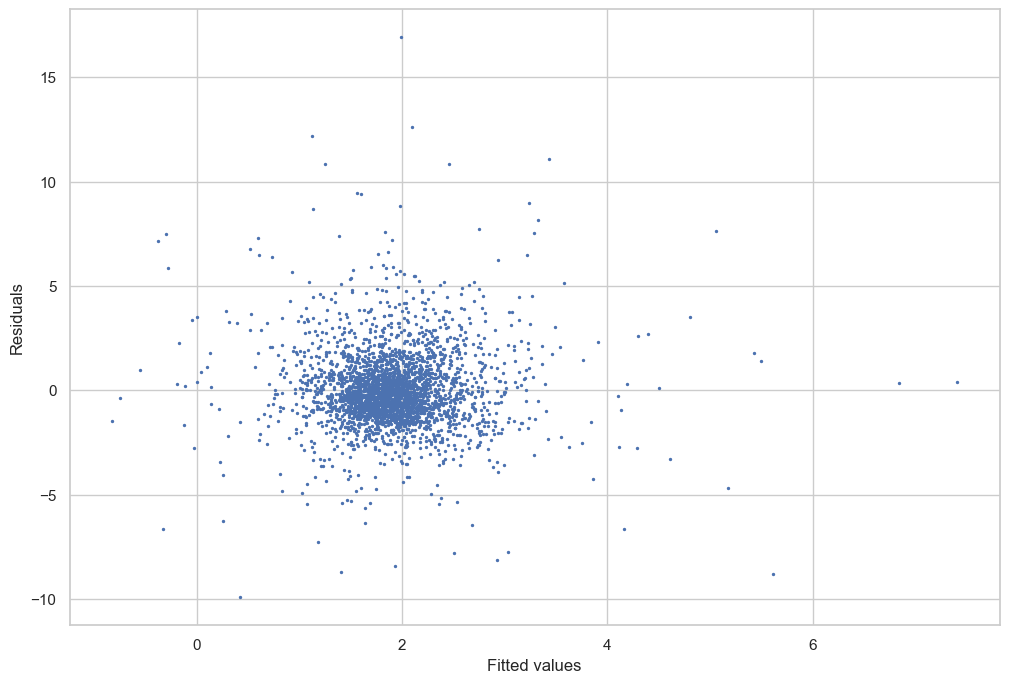

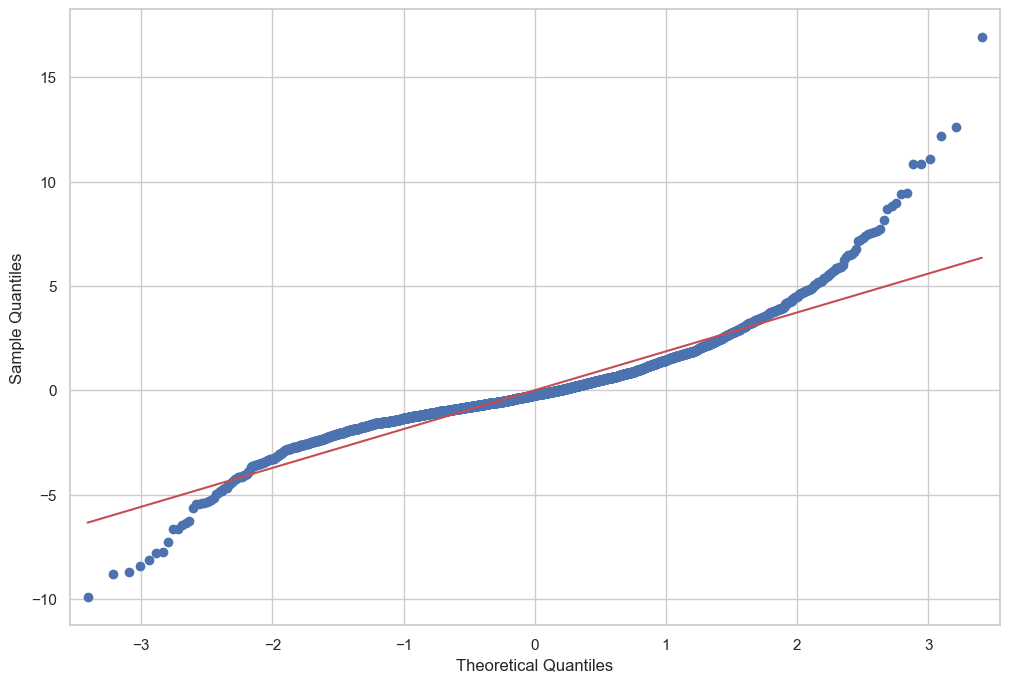

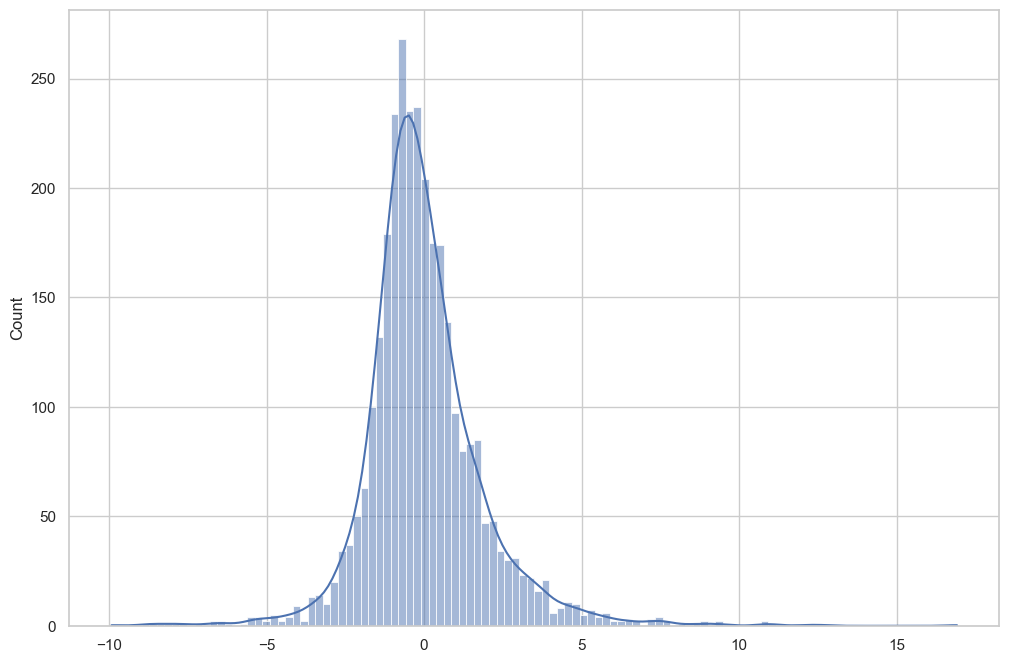

Mean Absolute Error: 1.2785313282983373
Root Mean Squared Error: 1.8615833232457089


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,1.901,0.034,56.360,"1.835 , 1.967",1.835,1.967
1,diff_acs_pct_age_gte65,-0.233,0.094,-2.493,"-0.417 , -0.05",-0.417,-0.05
2,diff_acs_pct_ed_9_12,0.145,0.092,1.564,"-0.037 , 0.326",-0.037,0.326
3,diff_acs_pct_ed_asc,0.413,0.086,4.828,"0.245 , 0.581",0.245,0.581
4,diff_acs_pct_ed_b,0.408,0.082,4.985,"0.247 , 0.568",0.247,0.568
5,diff_acs_pct_ed_gr,0.265,0.095,2.786,"0.079 , 0.452",0.079,0.452
6,diff_acs_pct_ed_hs,0.271,0.071,3.828,"0.132 , 0.409",0.132,0.409
7,diff_acs_pct_ed_sc,0.342,0.074,4.614,"0.197 , 0.487",0.197,0.487
8,diff_acs_pct_eth_hisp,0.017,0.010,1.709,"-0.003 , 0.037",-0.003,0.037
9,diff_acs_pct_occ_mgt,0.773,0.369,2.096,"0.05 , 1.497",0.05,1.497


In [55]:
X_struct = df[structural]
X_struct = X_struct - X_struct.mean()
X_struct = sm.add_constant(X_struct)

y = df[dv_struct]
#OLS with HC1 robust standard errors
model = sm.OLS(y, X_struct).fit(cov_type='HC1')

df['structural_internet_adoption'] = model.predict(X_struct)

#model summary
print(model.summary())

#plto residuals
fig, ax = plt.subplots()
ax.scatter(model.fittedvalues, model.resid, s=2) 
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

#QQ plot
fig, ax = plt.subplots()
sm.qqplot(model.resid, line='s', ax=ax)
plt.show()

#distribution of residuals
sns.histplot(model.resid, kde=True)
plt.show()


mae = np.mean(np.abs(model.resid))
print(f'Mean Absolute Error: {mae}')
rmse = np.sqrt(np.mean(model.resid**2))
print(f'Root Mean Squared Error: {rmse}')

#dataframe with variable names, coefficients, std err, standardised coefficients, t-values, 95% CI
results = pd.DataFrame(model.params, columns=['Coef'])
results['Std Err'] = model.bse
results['t'] = model.tvalues
results['95% CI'] = model.conf_int()[0]
#display CI as two string values in the column rounded to 4 decimal places
results['95% CI'] = results['95% CI'].round(3).astype(str) + ' , ' + model.conf_int()[1].round(3).astype(str)
#seperate the CI into two columns
results[['CI Lower', 'CI Upper']] = results['95% CI'].str.split(',', expand=True)
results = results.reset_index()
results = results.rename(columns={'index':'Variable'})
results = results.round(3)
display(results)
results.to_csv('../../02_data/02.03_results/structural_internet_adoption_results.csv', index=False)

In [56]:
intermediate = [
    'structural_internet_adoption',
    'diff_brfss_access2', 
    'diff_brfss_checkup',
    'diff_brfss_csmoking', 
    'diff_brfss_mhlth', 
    'diff_brfss_obesity',
    #'diff_acs_pct_tp_veh_0', reference
    'diff_acs_pct_tp_veh_1',
    'diff_acs_pct_tp_veh_2', 
    'diff_acs_pct_tp_veh_3'
]

In [57]:
print("Summary of Key Findings from First Difference Analysis:")
print("-" * 60)

# 1. Overall change
print(f"1. Average change in diabetes prevalence: {diff_df[diabetes_diff_col].mean():.4f}%")
print(f"   Range: {diff_df[diabetes_diff_col].min():.4f}% to {diff_df[diabetes_diff_col].max():.4f}%")

# 2. Most correlated changes
print("\n2. Changes most correlated with diabetes prevalence change:")
for var, corr in diabetes_corr.iloc[1:6].items():
    print(f"   - {var}: {corr:.4f}")

# 3. Key regional patterns
print("\n3. Counties with notable changes:")
print(f"   - Largest increase: {top_increase.iloc[0]['county_name']} ({top_increase.iloc[0][diabetes_diff_col]:.4f}%)")
print(f"   - Largest decrease: {top_decrease.iloc[0]['county_name']} ({top_decrease.iloc[0][diabetes_diff_col]:.4f}%)")

# 4. Statistical significance
print(f"\n4. Statistical significance: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("   - The change in diabetes prevalence is statistically significant")
else:
    print("   - The change in diabetes prevalence is not statistically significant")

Summary of Key Findings from First Difference Analysis:
------------------------------------------------------------
1. Average change in diabetes prevalence: 0.5660%
   Range: -3.7000% to 5.5000%

2. Changes most correlated with diabetes prevalence change:
   - diff_brfss_ghlth: 0.5613
   - diff_brfss_csmoking: 0.4775
   - diff_brfss_mhlth: 0.3732
   - diff_brfss_depression: 0.2810
   - diff_acs_pct_ses_pov: 0.2547

3. Counties with notable changes:
   - Largest increase: Kenedy County, Texas (5.5000%)
   - Largest decrease: Todd County, South Dakota (-3.7000%)

4. Statistical significance: p-value = 0.0000
   - The change in diabetes prevalence is statistically significant


                             OLS Regression Results                            
Dep. Variable:     diff_brfss_diabetes   R-squared:                       0.279
Model:                             OLS   Adj. R-squared:                  0.277
Method:                  Least Squares   F-statistic:                     95.13
Date:                 Tue, 01 Apr 2025   Prob (F-statistic):          7.34e-157
Time:                         09:12:07   Log-Likelihood:                -3038.1
No. Observations:                 3068   AIC:                             6096.
Df Residuals:                     3058   BIC:                             6156.
Df Model:                            9                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

C:\Users\mfarm\AppData\Local\Temp\ipykernel_45556\3076068299.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='variable', data=coefs, palette=colors)


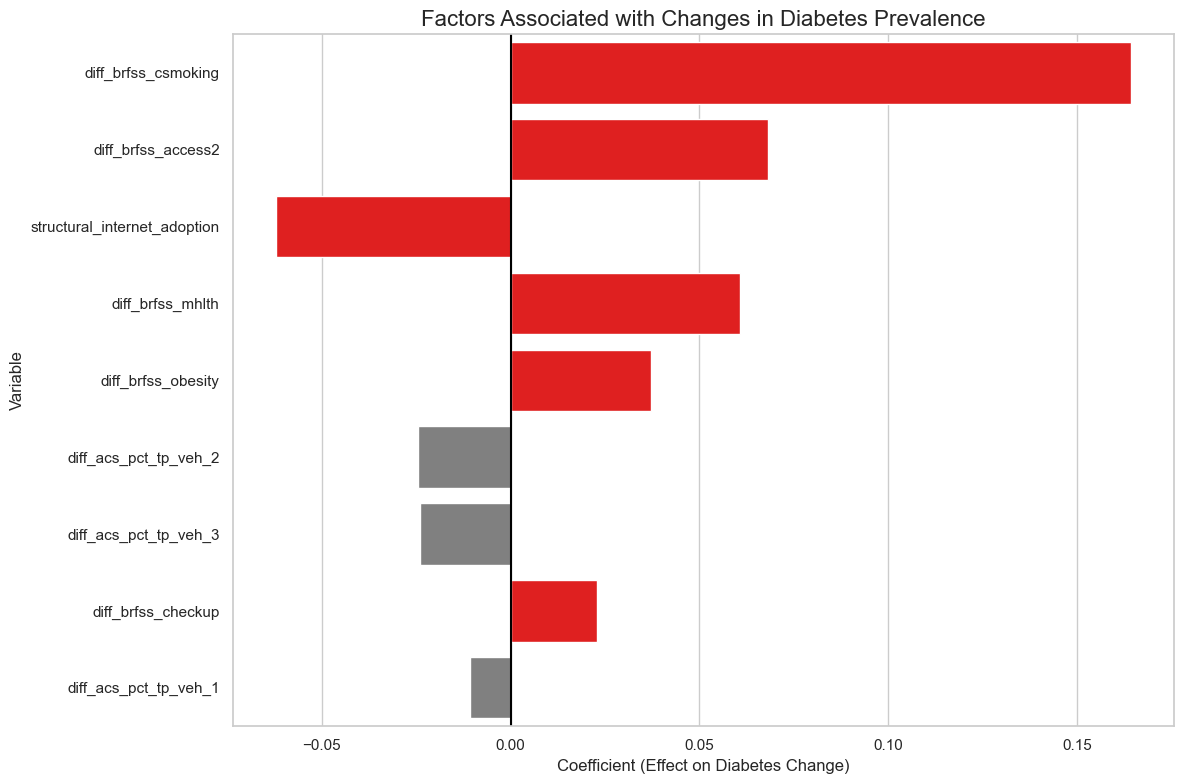


Breusch-Pagan test for heteroscedasticity
LM statistic: 114.0242
LM test p-value: 0.0000
F statistic: 13.1155
F test p-value: 0.0000
There is evidence of heteroscedasticity (robust standard errors may be needed)


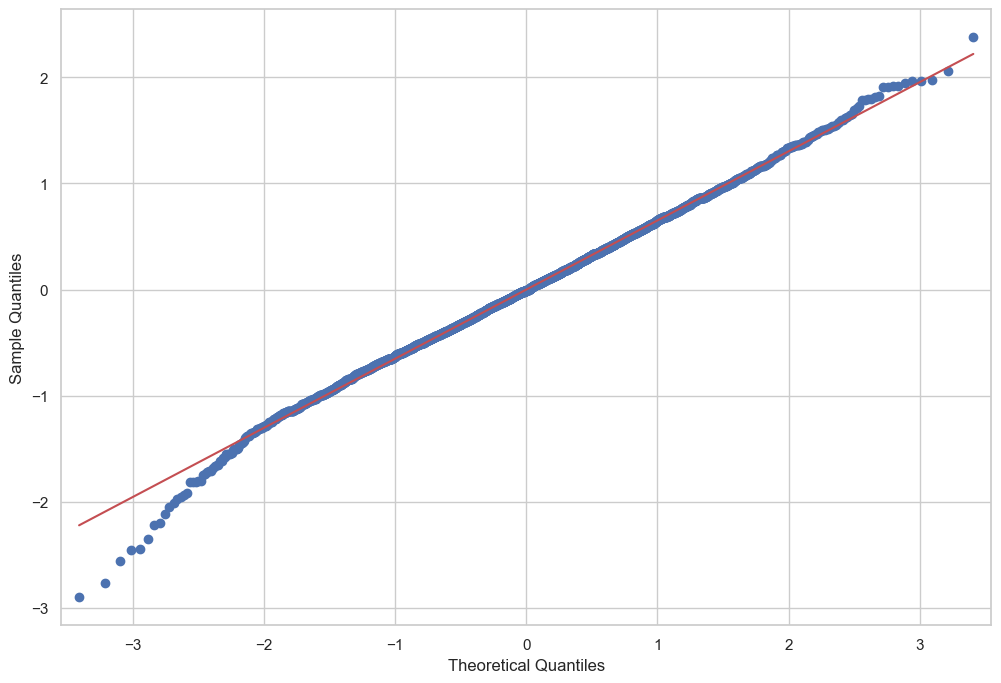

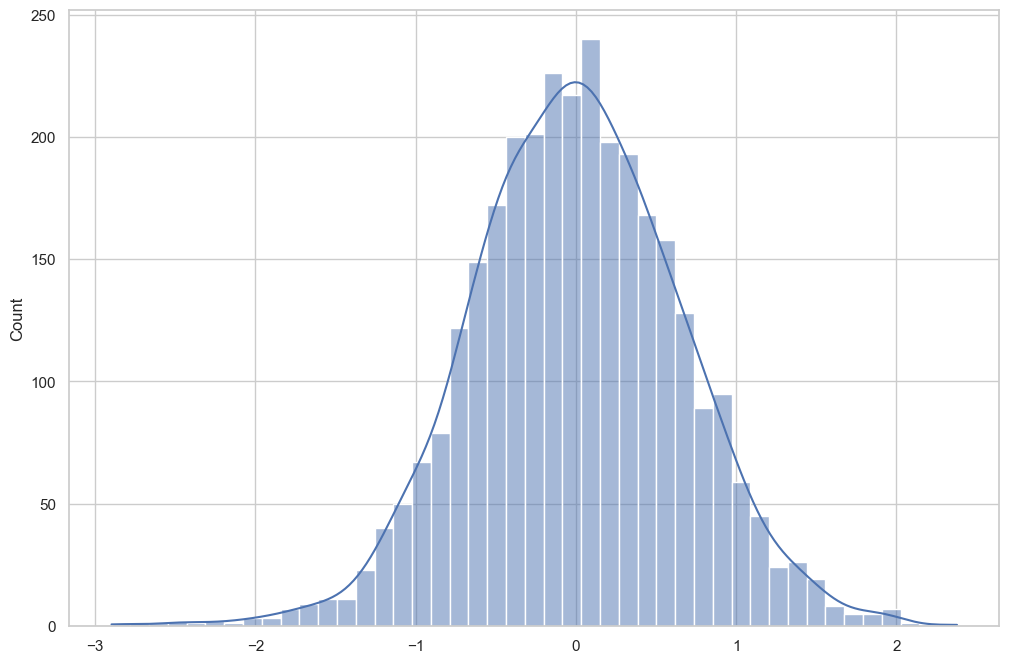

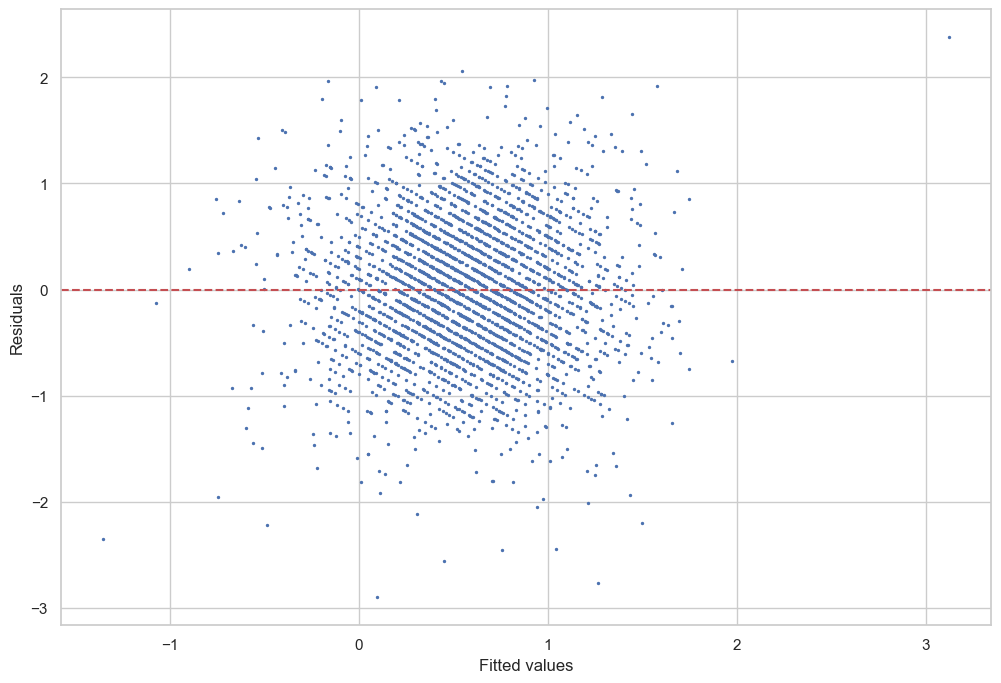

Mean Absolute Error: 0.5132627896482097
Root Mean Squared Error: 0.65136249241046


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,0.741,0.063,11.761,"0.617 , 0.864",0.617,0.864
1,structural_internet_adoption,-0.062,0.028,-2.199,"-0.118 , -0.007",-0.118,-0.007
2,diff_brfss_access2,0.068,0.009,7.871,"0.051 , 0.085",0.051,0.085
3,diff_brfss_checkup,0.023,0.006,3.702,"0.011 , 0.035",0.011,0.035
4,diff_brfss_csmoking,0.164,0.011,15.067,"0.143 , 0.186",0.143,0.186
5,diff_brfss_mhlth,0.061,0.018,3.458,"0.026 , 0.095",0.026,0.095
6,diff_brfss_obesity,0.037,0.005,8.171,"0.028 , 0.046",0.028,0.046
7,diff_acs_pct_tp_veh_1,-0.011,0.016,-0.667,"-0.042 , 0.021",-0.042,0.021
8,diff_acs_pct_tp_veh_2,-0.025,0.016,-1.536,"-0.056 , 0.007",-0.056,0.007
9,diff_acs_pct_tp_veh_3,-0.024,0.017,-1.437,"-0.057 , 0.009",-0.057,0.009


In [58]:
# Add constant
X = sm.add_constant(df[intermediate])
y = df[dv_int]

# Fit regression model
model = sm.OLS(y, X).fit(cov_type='HC3')

fitted_values = model.fittedvalues
residuals = model.resid

# Display results
print(model.summary())

# Create a dataframe of coefficients for easier visualization
coefs = pd.DataFrame({
    'variable': intermediate,
    'coefficient': model.params[1:],
    'p_value': model.pvalues[1:]
})

# Sort by absolute coefficient size
coefs['abs_coef'] = coefs['coefficient'].abs()
coefs = coefs.sort_values('abs_coef', ascending=False)

# Visualize coefficients
plt.figure(figsize=(12, 8))
colors = ['red' if p < 0.05 else 'gray' for p in coefs['p_value']]
sns.barplot(x='coefficient', y='variable', data=coefs, palette=colors)
plt.axvline(x=0, color='black', linestyle='-')
plt.title('Factors Associated with Changes in Diabetes Prevalence', fontsize=16)
plt.xlabel('Coefficient (Effect on Diabetes Change)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()


# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, model.model.exog)
print("\nBreusch-Pagan test for heteroscedasticity")
print(f"LM statistic: {bp_test[0]:.4f}")
print(f"LM test p-value: {bp_test[1]:.4f}")
print(f"F statistic: {bp_test[2]:.4f}")
print(f"F test p-value: {bp_test[3]:.4f}")
if bp_test[1] < 0.05:
    print("There is evidence of heteroscedasticity (robust standard errors may be needed)")
else:
    print("No significant evidence of heteroscedasticity")

fig = sm.qqplot(residuals, line='s')
plt.show()

#plot residuals on histogram
sns.histplot(residuals, kde=True)
plt.show()

#plot residuals on scatter, small dots
plt.scatter(model.fittedvalues, residuals, s=2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

mae = np.mean(np.abs(residuals))
print(f'Mean Absolute Error: {mae}')
rmse = np.sqrt(np.mean(residuals**2))
print(f'Root Mean Squared Error: {rmse}')

#dataframe with variable names, coefficients, std err, t-values, 95% CI, round to 3 decimal places, seperate CI into two columns
results = pd.DataFrame(model.params, columns=['Coef'])
results['Std Err'] = model.bse
results['t'] = model.tvalues
results['95% CI'] = model.conf_int()[0]
results['95% CI'] = results['95% CI'].round(3).astype(str) + ' , ' + model.conf_int()[1].round(3).astype(str)
results[['CI Lower', 'CI Upper']] = results['95% CI'].str.split(',', expand=True)
results = results.reset_index()
results = results.rename(columns={'index':'Variable'})
results = results.round(3)
display(results)

In [62]:
df.head()

#export results to csv
results.to_csv('../../02_data/02.03_results/diff_acs_brfss_results_w_structural_internet_adoption.csv', index=False)
#export df
df.to_csv('../../02_data/02.03_results/struct_acs_brfss.csv', index=False)
